### GOES-16 ABI and Gaylor Pit in Tuolumne

#### Analysis and plotting of snow surface and brightness temperatures (2017-2020)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import os
import datetime as dt
import xarray as xr
from scipy import stats
import re
from scipy.signal import argrelextrema, argrelmax

# pretty print++ and pretty print
import pprintpp
pprintpp.monkeypatch()
import pprint

import warnings
warnings.filterwarnings('ignore')

# Import functions for computing summary statistics
import resampled_stats as rs

# use this function to match the date/time of observations
def nearest(items, pivot):
    # https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/pprintpp/__init__.py:171: UserWarning: 'pprint' has already been imported; monkeypatching won't work everywhere.
  warnings.warn("'pprint' has already been imported; monkeypatching "


Set font sizes for plots

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

---

# Open dataset

Gaylor Pit dataset which is the merged GOES-16 brightness temperature, GOES-16 ABI Cloud Mask, and Gaylot Pit station data:

In [3]:
tuol_ds = pd.read_pickle('data/goes-tuolumne_2017-2020.pkl')
tuol_ds = tuol_ds.to_xarray().squeeze()

### Filter entire dataset to only snow-on conditions, cloud-free, November through June each year

Set thresholds for where we want to ignore snow surface temperature and GOES brightness temperature measurements. It looks like I can be safe by saying "no snow" is anywhere below 5 cm of snow depth. I'll use the daily median snow depth to check this.

And of course we want no cloud-cover, so only look at where ABI Cloud Mask=0.

There are very few data points within Fall months, and we don't want to look at the summer past snowmelt. Filter to only look at November through June each year.

In [5]:
# Set snow depth threshold for filtering data to snow-on conditions only
snow_depth_treshold = 5 # cm

##### Create a filter, combining the "snow-on" and "ABI cloud mask" filters
filter_conditions_ABIcloud_snowdepth_months = ((tuol_ds.ABI_Cloud_Mask == 0) & \
                                               (tuol_ds.daily_median_snow_depth >= snow_depth_treshold) & \
                                               (tuol_ds.time.dt.month.isin([1,2,3,4,5,6,11,12])))
tuol_snow_abicloud = tuol_ds.where(filter_conditions_ABIcloud_snowdepth_months) # Apply this filter

(736695.0, 736726.0)

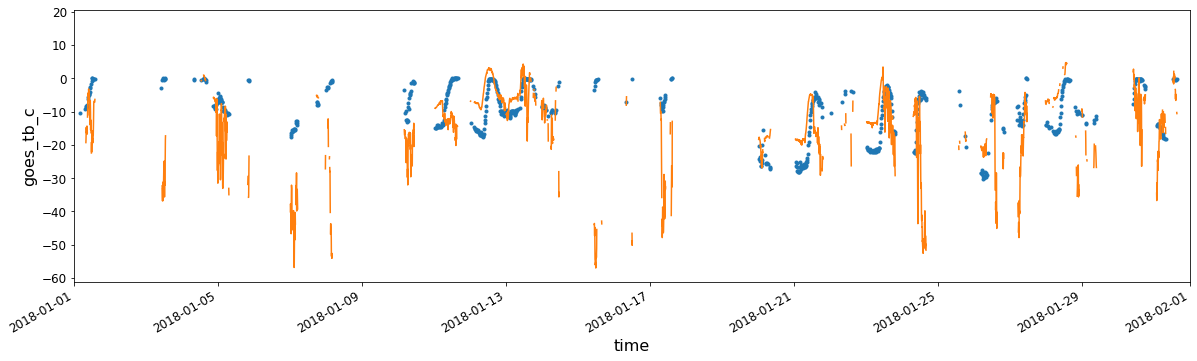

In [31]:
plt.figure(figsize=(20,5))
tuol_snow_abicloud.tss.plot(marker='.')
tuol_snow_abicloud.goes_tb_c.plot()

plt.xlim((pd.Timestamp('2018-1-1'),pd.Timestamp('2018-2-1')))

---
---
---

# Summary stats for the full time period

And a plot showing the overal change due to orthorectifying the ABI imagery. Although we see a difference here in the timeseries, any "improvement" isn't really apparent. It is much more apparent when we look at the GOES versus ASTER plots when we can actually visually see the spatial misalignment without orthorectifying the GOES imagery.

Not Orthorectified (original ABI projection):
{
    'intercept': -6.613989275621738,
    'max_diff': 16.820443117965937,
    'mean_diff': -2.558112169492482,
    'mean_squared_diff': 125.16735753066979,
    'median_diff': 0.46810973862161775,
    'min_diff': -56.436474247905586,
    'n': 16426,
    'p_value': 0.0,
    'r_value': 0.38528922249348463,
    'range_diff': 73.25691736587152,
    'rms_diff': 11.18782184031681,
    'slope': 0.546237873246829,
    'std_diff': 10.891437905940807,
    'std_err': 0.010208480909302268,
}
Orthorectified:
{
    'intercept': -4.693966261101526,
    'max_diff': 19.292534336384907,
    'mean_diff': -0.3935443031439435,
    'mean_squared_diff': 131.78113095164346,
    'median_diff': 3.141162616218467,
    'min_diff': -55.59792801395301,
    'n': 16426,
    'p_value': 0.0,
    'r_value': 0.3526086641158621,
    'range_diff': 74.89046235033791,
    'rms_diff': 11.479596288704732,
    'slope': 0.5188787622213819,
    'std_diff': 11.472848549209841,
    'std

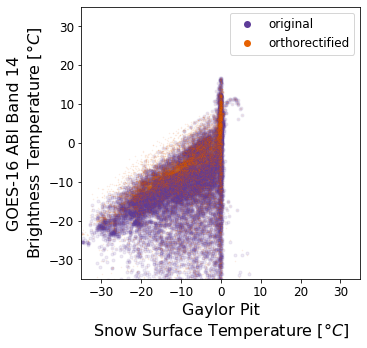

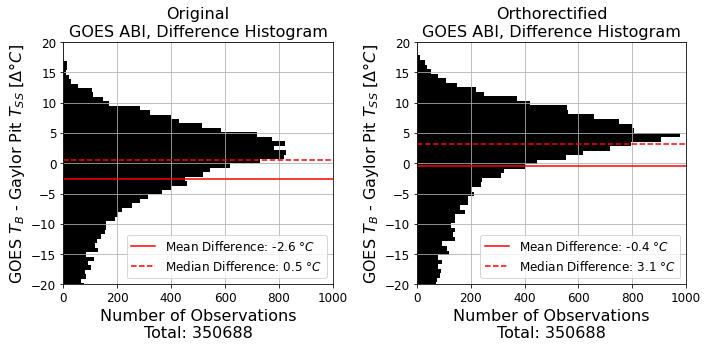

In [12]:
x1 = tuol_snow_abicloud.tss
y1 = tuol_snow_abicloud.goes_tb_not_orthorectified_c

print("Not Orthorectified (original ABI projection):")
original_summary_stats = rs.summary_stats(x1, y1)
pprint.pprint(original_summary_stats)

x2 = tuol_snow_abicloud.tss
y2 = tuol_snow_abicloud.goes_tb_c

print("Orthorectified:")
ortho_summary_stats = rs.summary_stats(x2, y2)
pprint.pprint(ortho_summary_stats)


### Make 1-to-1 plot
plt.figure(figsize=(5,5))

plt.plot(x1, y1, '.', color='#5e3c99', alpha=0.1, label='original GOES')
plt.plot(x2, y2, '.', color='#e66101', alpha=0.1,markersize=1, label='orthorectified GOES')


legend_elements= [Line2D([0], [0], marker='o', color='none', label='original',
                          markerfacecolor='#5e3c99', markeredgecolor='none', markersize=7),
                  Line2D([0], [0], marker='o', color='none', label='orthorectified',
                          markerfacecolor='#e66101', markeredgecolor='none', markersize=7)]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlim((-35,35))
plt.ylim((-35,35));

plt.xlabel('Gaylor Pit\nSnow Surface Temperature [$\degree C$]')
plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');

### Make histograms


nbins=100
xmin=0
xmax=1000
ymin=-20
ymax=20


fig, [ax1, ax2] = plt.subplots(1,2,figsize=(10,5),tight_layout=True)

# original, not-orthorectified, difference histogram
tuol_snow_abicloud.goes_tuol_diff_not_orthorectified.plot.hist(ax=ax1,
                                                                  bins=nbins, 
                                                                  orientation='horizontal',
                                                                  color = '#000000',
                                                                  ec='none',
                                                                  lw=1)
#ax1.axhline(0,color='lightgrey',linestyle='-')
ax1.grid('on')
ax1.set_title('Original\nGOES ABI, Difference Histogram')
ax1.set_xlabel('Number of Observations\nTotal: {}'.format(tuol_snow_abicloud.goes_tuol_diff_not_orthorectified.size))
ax1.set_xlim((xmin,xmax))
ax1.set_ylim(ymin,ymax);
ax1.set_ylabel('GOES $T_{B}$ - Gaylor Pit $T_{SS}$ [$\Delta\degree C$]')
ax1.axhline(original_summary_stats['mean_diff'], color='r', label='Mean Difference: {} $\degree C$'.format(np.round(original_summary_stats['mean_diff'],1)))
ax1.axhline(original_summary_stats['median_diff'], color='r', linestyle='--', label='Median Difference: {} $\degree C$'.format(np.round(original_summary_stats['median_diff'],1)))
ax1.legend(loc='lower right')

# orthorectified difference histogram

### Original Dataframe, Histogram ###
tuol_snow_abicloud.goes_tuol_diff.plot.hist(ax=ax2,
                                               bins=nbins, 
                                               orientation='horizontal',
                                               color = '#000000',
                                               ec='none',
                                               lw=1)
#ax2.axhline(0,color='lightgrey',linestyle='-')
ax2.grid('on')
ax2.set_title('Orthorectified\nGOES ABI, Difference Histogram')
ax2.set_xlabel('Number of Observations\nTotal: {}'.format(tuol_snow_abicloud.goes_tuol_diff.size))
ax2.set_xlim((xmin,xmax))
ax2.set_ylim(ymin,ymax);
ax2.set_ylabel('GOES $T_{B}$ - Gaylor Pit $T_{SS}$ [$\Delta\degree C$]')
ax2.axhline(ortho_summary_stats['mean_diff'], color='r', label='Mean Difference: {} $\degree C$'.format(np.round(ortho_summary_stats['mean_diff'],1)))
ax2.axhline(ortho_summary_stats['median_diff'], color='r', linestyle='--', label='Median Difference: {} $\degree C$'.format(np.round(ortho_summary_stats['median_diff'],1)))
ax2.legend(loc='lower right')

---

# Boxplots and Histograms

Resample, compute summary stats

In [6]:
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 1M resample

Summary Stats for full cues_snow_cloud dataset
{
    'intercept': -4.693966261101526,
    'max_diff': 19.292534336384907,
    'mean_diff': -0.3935443031439435,
    'mean_squared_diff': 131.78113095164346,
    'median_diff': 3.141162616218467,
    'min_diff': -55.59792801395301,
    'n': 16426,
    'p_value': 0.0,
    'r_value': 0.3526086641158621,
    'range_diff': 74.89046235033791,
    'rms_diff': 11.479596288704732,
    'slope': 0.5188787622213819,
    'std_diff': 11.472848549209841,
    'std_err': 0.010744914689790759,
}


Text(0, 0.5, 'Snow Depth [cm]')

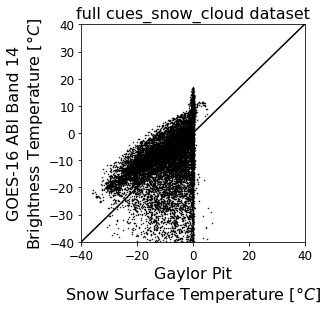

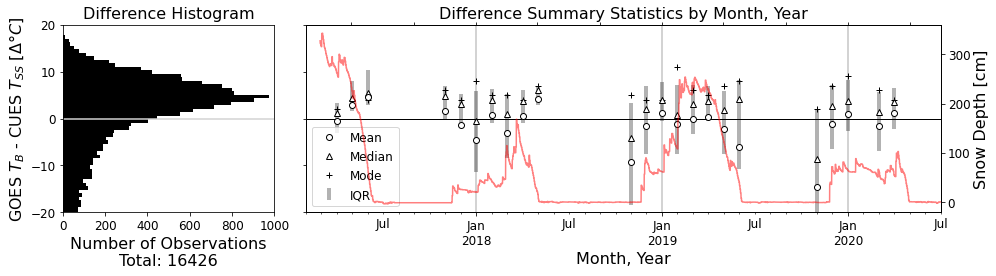

In [18]:
# Compute summary stats for whole dataset
x = tuol_snow_abicloud.tss
y = tuol_snow_abicloud.goes_tb_c
print("Summary Stats for full cues_snow_cloud dataset")
original_summary_stats = rs.summary_stats(x, y)
pprint.pprint(original_summary_stats)
# Make a 1-to-1 plot for the same data in the histogram
plt.figure(figsize=(4,4))
plt.title('full cues_snow_cloud dataset')
plt.plot(x, y, '.k',alpha=1, markersize=1)
(min_lim, max_lim) = (-40, 40)
plt.xlim((min_lim,max_lim))
plt.ylim((min_lim,max_lim));
plt.xlabel('Gaylor Pit\nSnow Surface Temperature [$\degree C$]')
plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');
plt.plot([min_lim,max_lim],[min_lim,max_lim],'-k')

# Create DataArrayResample object
resampled_ds = tuol_snow_abicloud.goes_tuol_diff.resample(time='1M')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)

startdate = pd.Timestamp('2017-02-01')
enddate = pd.Timestamp('2020-07-01')

# Plot the results
fig, ax = rs.resampled_plot(tuol_snow_abicloud.goes_tuol_diff.to_dataframe(), resampled_df, ymin=-20, ymax=20, xmin=0, xmax=1000, nbins=100)
# Add grid
ax[1].grid(which='major', axis='x', color='lightgrey', lw=2)
ax[1].set_xlim((startdate,enddate));
ax[1].set_title('Difference Summary Statistics by Month, Year');
ax[1].set_xlabel('Month, Year');
#
## add snow depth line for context
snowdepth_ax = ax[1].twiny().twinx()
snowdepth_ax.set_xlim((startdate,enddate));
snowdepth_ax.set_xticklabels([])
tuol_ds.daily_median_snow_depth.plot(color='red',label='Daily Median Snow Depth', ax=snowdepth_ax, alpha=0.5)
snowdepth_ax.set_ylabel('Snow Depth [cm]')
#snowdepth_ax.legend(loc='upper right')

### Month of Year groupby

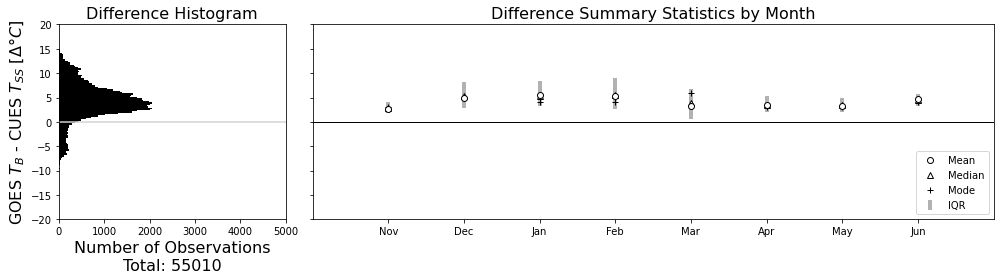

In [12]:
# Create DataArrayResample object
resampled_ds = cues_snow_abicloud.goes_cues_diff.groupby('time.month')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)

def month_of_wy(month):
    ''' return month of wateryear (starting with October = 1, ending with September = 12)
    based on: https://stackoverflow.com/questions/52105804/how-to-convert-calendar-year-to-water-year-in-pandas'''
    if month>=10:
        return(month-9)
    else:
        return(month+3)

# calculate month of wateryear from calendar month
resampled_df['month_of_wateryear'] = [month_of_wy(month) for month in resampled_df.index]
resampled_df.set_index('month_of_wateryear', inplace=True)

# Plot the results
fig, ax = rs.resampled_plot(cues_snow_abicloud.goes_cues_diff.to_dataframe(), resampled_df, ymin=-20, ymax=20, xmin=0, xmax=5000, nbins=300)
 # format axis, limits and labels
ax[1].set_xlim((1,10))
ax[1].set_xticks(np.arange(2, 10, 1.0))
month_labels = [  'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
ax[1].set_xticklabels(month_labels)
ax[1].set_title('Difference Summary Statistics by Month')
ax[1].set_xlabel('')
ax[1].legend(loc='lower right')

### Week of Year groupby

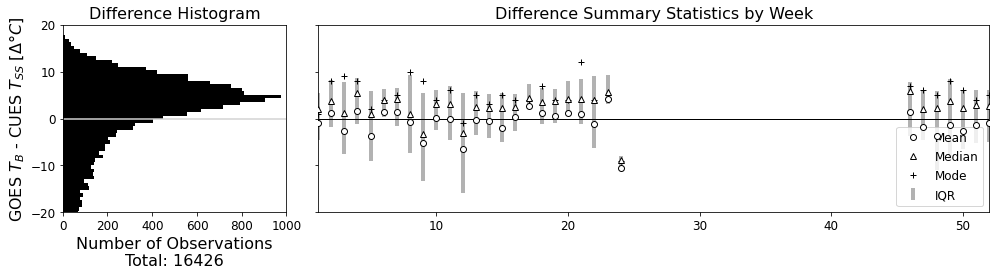

In [20]:
# Create DataArrayResample object
resampled_ds = tuol_snow_abicloud.goes_tuol_diff.groupby('time.week')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)


def week_of_wy(week):
    ''' return week of wateryear (starting with 1st week of October = 1, ending with last week of September = 52)
    based on: https://stackoverflow.com/questions/52105804/how-to-convert-calendar-year-to-water-year-in-pandas'''
    if week>=40:
        return(week-39)
    else:
        return(week+13)

# calculate month of wateryear from calendar month
resampled_df['week_of_wateryear'] = [week_of_wy(week) for week in resampled_df.index]
#resampled_df.set_index('week_of_wateryear', inplace=True)

# Plot the results
fig, ax = rs.resampled_plot(tuol_snow_abicloud.goes_tuol_diff.to_dataframe(), resampled_df, ymin=-20, ymax=20, xmin=0, xmax=1000, nbins=100)
 # format axis, limits and labels
#ax[1].set_xlim((0,44))
#ax[1].set_xticks(np.concatenate((np.arange(40,52), np.arange(0,39))))
#month_labels = [ 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
#ax[1].set_xticklabels(month_labels)
ax[1].set_title('Difference Summary Statistics by Week')
ax[1].set_xlabel('')
ax[1].legend(loc='lower right')

### Hour of Day, by Month groupby

Month: 3
{
    'intercept': -8.37654924633257,
    'max_diff': 18.02729649747987,
    'mean_diff': -1.4361545755285485,
    'mean_squared_diff': 141.29703842256941,
    'median_diff': 1.8623311280740291,
    'min_diff': -51.531538823511355,
    'n': 2480,
    'p_value': 2.205294840321088e-30,
    'r_value': 0.22713483249630564,
    'range_diff': 69.55883532099122,
    'rms_diff': 11.88684308058996,
    'slope': 0.29751496321689214,
    'std_diff': 11.799766881500576,
    'std_err': 0.02562550484332031,
}
Month: 4
{
    'intercept': -1.4346684147323026,
    'max_diff': 17.17294769808552,
    'mean_diff': 0.48583151835011795,
    'mean_squared_diff': 96.24091565826146,
    'median_diff': 3.190836845603223,
    'min_diff': -53.6101603076279,
    'n': 3048,
    'p_value': 1.5162169364335523e-90,
    'r_value': 0.3537550872188363,
    'range_diff': 70.78310800571342,
    'rms_diff': 9.81024544332411,
    'slope': 0.6352660461055588,
    'std_diff': 9.798208172622129,
    'std_err': 0.030433

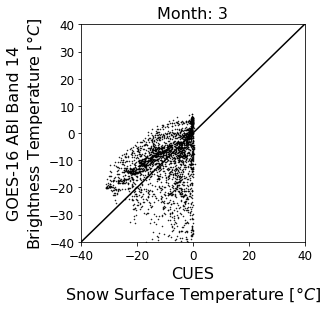

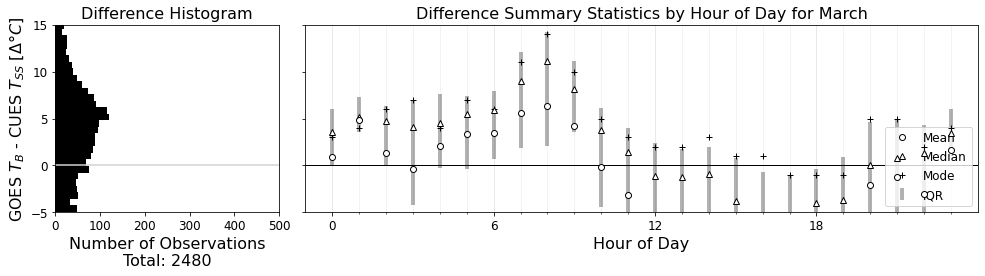

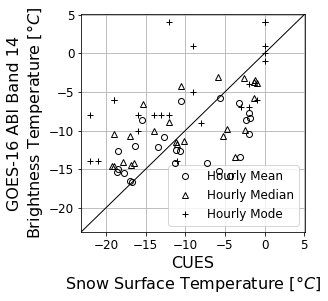

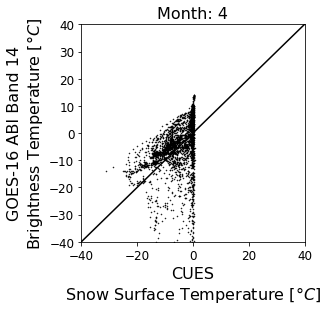

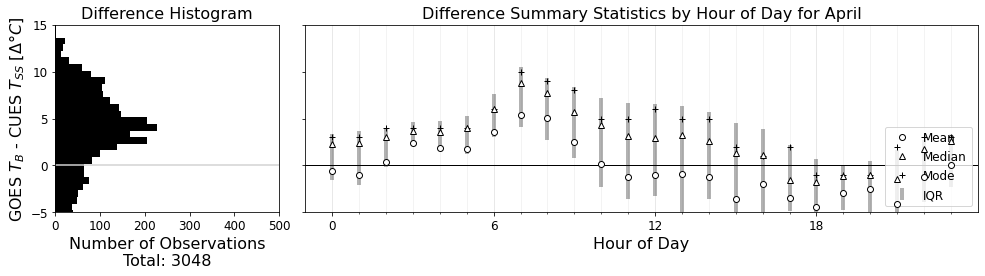

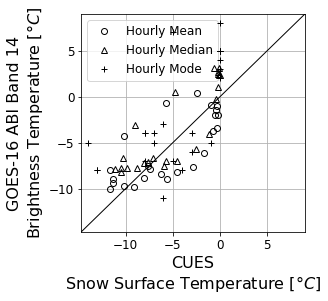

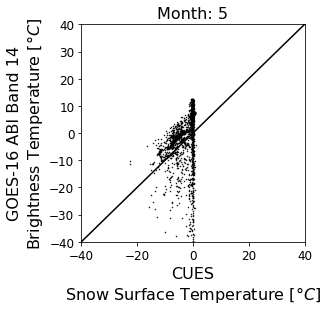

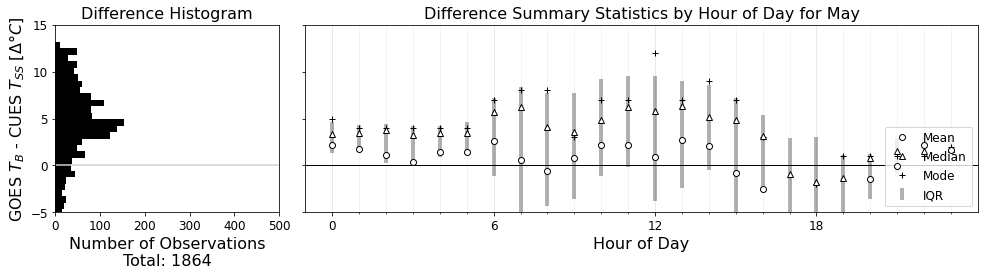

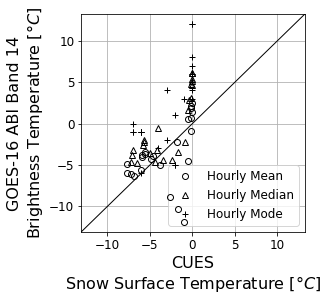

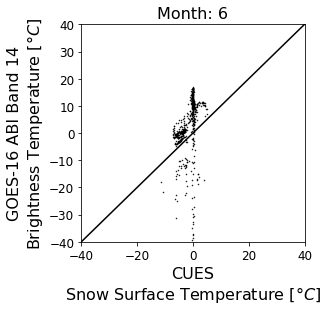

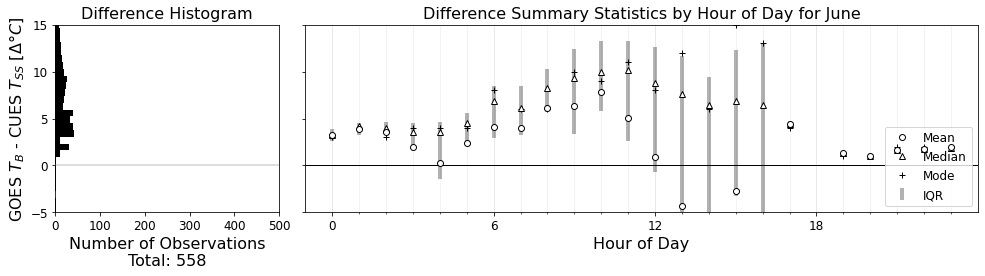

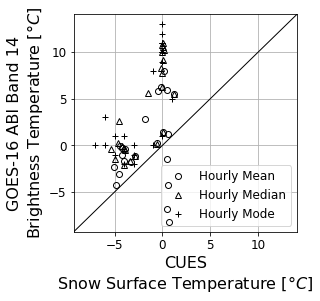

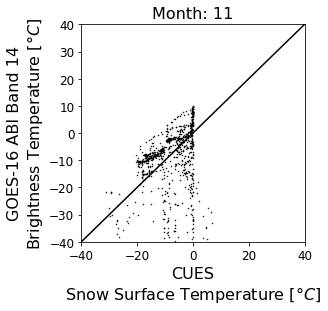

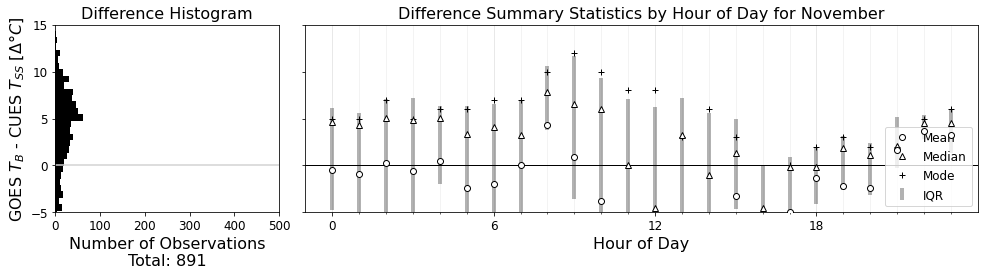

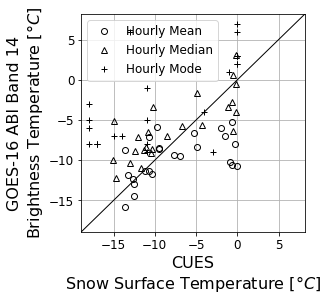

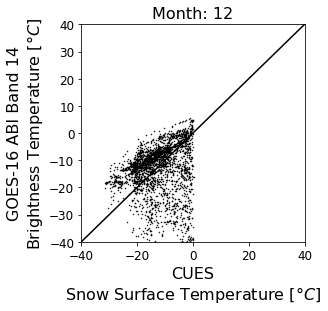

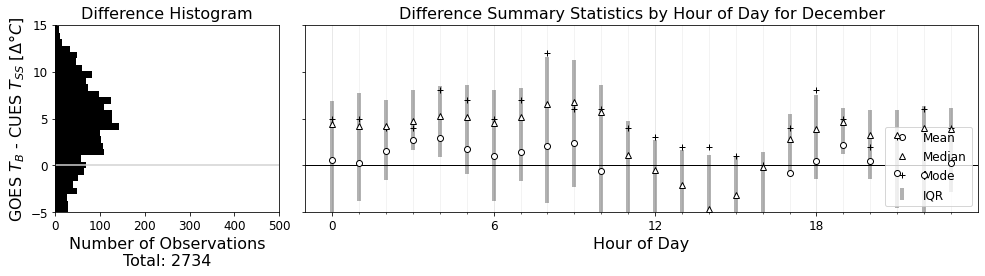

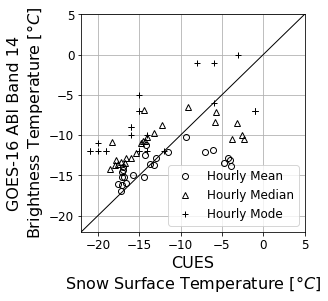

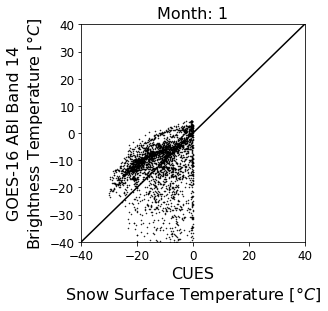

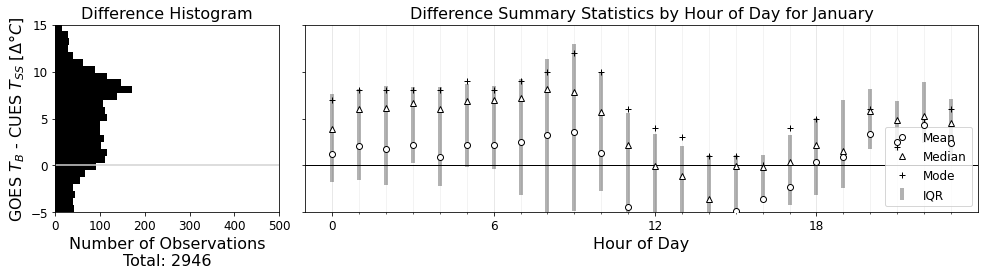

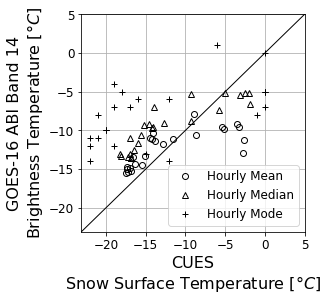

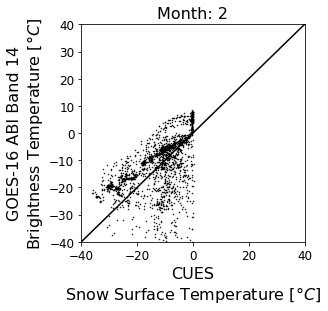

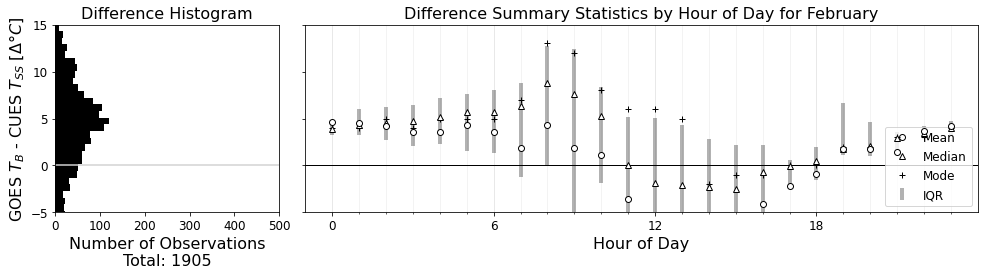

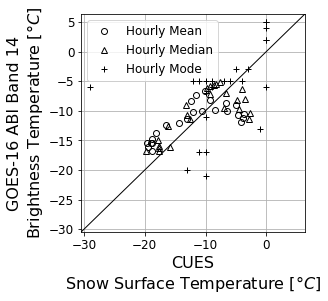

In [25]:
df = tuol_snow_abicloud.to_dataframe()

for month in df.index.month.unique():
    month_name = dt.date(1900, month, 1).strftime('%B')
    mask = df.index.month==month
    df_m = df.loc[mask]
    
    # Only look at aggregate months were we have data points (skipping summer months)
    if df_m.goes_tuol_diff.count() >= 1:
        
        # Compute summary stats for this aggregated month
        x = df_m.tss
        y = df_m.goes_tb_c
        print("Month: {}".format(month))
        original_summary_stats = rs.summary_stats(x, y)
        pprint.pprint(original_summary_stats)
        # Make a 1-to-1 plot for the same data in the histogram
        plt.figure(figsize=(4,4))
        plt.title('Month: {}'.format(month))
        plt.plot(x, y, '.k',alpha=1, markersize=1)
        (min_lim, max_lim) = (-40, 40)
        plt.xlim((min_lim,max_lim))
        plt.ylim((min_lim,max_lim));
        plt.xlabel('CUES\nSnow Surface Temperature [$\degree C$]')
        plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');
        plt.plot([min_lim,max_lim],[min_lim,max_lim],'-k')

        # Create DataArrayResample object
        resampled_ds = df_m.groupby(df_m.index.hour)
        # Run the resampled_stats function
        resampled_df = rs.resampled_stats(resampled_ds.goes_tuol_diff, 0)
        
        # Plot the results
        nbins = 100#int(np.sqrt(df_m.goes_cues_diff.count()))+1
        fig, ax = rs.resampled_plot(df_m.goes_tuol_diff, resampled_df, ymin=-5, ymax=15, xmin=0, xmax=500, nbins=nbins)
        ax[1].set_title('Difference Summary Statistics by Hour of Day for {}'.format(month_name))
        ax[1].set_xlabel('Hour of Day')
        ax[1].legend(loc='lower right')
        # Set major ticks and add grid
        ax[1].set_xticks(np.arange(0,24,6))
        ax[1].set_xticks(np.arange(0,24,1), minor = True)
        ax[1].set_xlim((-1,24))
        ax[1].grid(which='major', axis='x', color='lightgrey', lw=1, alpha=0.5);
        ax[1].grid(which='minor', axis='x', color='lightgrey', lw=1, alpha=0.25);
        
        ### add another 1-to-1 plot
        resampled_x = resampled_ds.tss
        resampled_y = resampled_ds.goes_tb_c
        fig3, ax3 = plt.subplots(figsize=(4,4))
        ax3.plot(rs.resampled_stats(resampled_x, 0)['means'], rs.resampled_stats(resampled_y, 0)['means'], linestyle='none',marker='o',markerfacecolor='none',markeredgecolor='k', zorder=99, label='Hourly Mean')
        ax3.plot(rs.resampled_stats(resampled_x, 0)['medians'], rs.resampled_stats(resampled_y, 0)['medians'], linestyle='none',marker='^',markerfacecolor='none',markeredgecolor='k', zorder=98, label='Hourly Median')
        ax3.plot(rs.resampled_stats(resampled_x, 0)['modes'], rs.resampled_stats(resampled_y, 0)['modes'], linestyle='none',marker='+',color='k', zorder=97, label='Hourly Mode')
        ax_lim_min = min(-5, ax3.get_xlim()[0], ax3.get_ylim()[0])
        ax_lim_max = max(5, ax3.get_xlim()[1], ax3.get_ylim()[1])
        ax3.plot([ax_lim_min,ax_lim_max],[ax_lim_min,ax_lim_max],linestyle='-',color='k', lw=1)
        ax3.grid('on')
        ax3.set_xlim((ax_lim_min,ax_lim_max))
        ax3.set_ylim((ax_lim_min,ax_lim_max))
        ax3.set_xlabel('CUES\nSnow Surface Temperature [$\degree C$]')
        ax3.set_ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');
        ax3.legend()